# Imports

In [244]:
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost.sklearn import XGBClassifier

# Loading the Data

In [245]:
# Считываем train и test датасеты
train_df = pd.read_csv('PD-data-train.csv', sep=';')
test_df = pd.read_csv('PD-data-test.csv', sep=';')

In [246]:
# Слияем датасеты
df = train_df.append(test_df)

In [247]:
df.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m,set
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,...,3,3,[1-100],50000.0,2,0,0,0,0.0,train
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,12,[1-100],10000.0,5,0,0,0,0.0,train
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28,28,[1-100],10000.0,2,0,0,0,0.0,train
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,...,8,8,[1-100],300000.0,1,0,0,0,0.0,train
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,...,27,27,[1-100],10000.0,2,0,0,0,0.0,train


# EDA

### General Info

In [248]:
print('Number of rows in test dataframe: ', test_df.shape[0])
print('Number of columns in test dataframe: ', test_df.shape[1])
print('Number of values in test dataframe: ', test_df.count().sum())
print('Number of NaNs in test dataframe: ', sum(test_df.isna().sum()))

Number of rows in test dataframe:  200
Number of columns in test dataframe:  37
Number of values in test dataframe:  4568
Number of NaNs in test dataframe:  2832


In [249]:
print('Number of rows in train dataframe: ', train_df.shape[0])
print('Number of columns in train dataframe: ', train_df.shape[1])
print('Number of values in train dataframe: ', train_df.count().sum())
print('Number of NaNs in train dataframe: ', sum(train_df.isna().sum()))

Number of rows in train dataframe:  32395
Number of columns in train dataframe:  38
Number of values in train dataframe:  867530
Number of NaNs in train dataframe:  363480


In [250]:
print('Number of rows in dataframe: ', df.shape[0])
print('Number of columns in dataframe: ', df.shape[1])
print('Number of values in dataframe: ', df.count().sum())
print('Number of NaNs in dataframe: ', sum(df.isna().sum()))

Number of rows in dataframe:  32595
Number of columns in dataframe:  38
Number of values in dataframe:  872098
Number of NaNs in dataframe:  366512


### Missing Values

In [251]:
print('Number of NaNs in train_df in all columns:\n')
count = df.isnull().sum().sort_values(ascending=False)
percentage = ((df.isnull().sum()/len(df)*100)).sort_values(ascending=False)
missing = pd.concat([count, percentage], axis=1, keys=['Count','Percentage'])
missing

Number of NaNs in train_df in all columns:



,Count,Percentage
ab_own_capital,15263,46.826200
ab_mobile_current_assets,15263,46.826200
ab_other_borrowings,15263,46.826200
ab_accounts_payable,15263,46.826200
ab_short_term_borrowing,15263,46.826200
ab_long_term_liabilities,15263,46.826200
ab_borrowed_capital,15263,46.826200
ar_revenue,15263,46.826200
ab_losses,15263,46.826200
ab_cash_and_securities,15263,46.826200


### Distribution of Data Points among Output Class

In [252]:
df['default_12m'].value_counts()

0.0    30304
1.0     2091
Name: default_12m, dtype: int64

In [253]:
train_df['default_12m'].values.mean()

0.06454699799351751

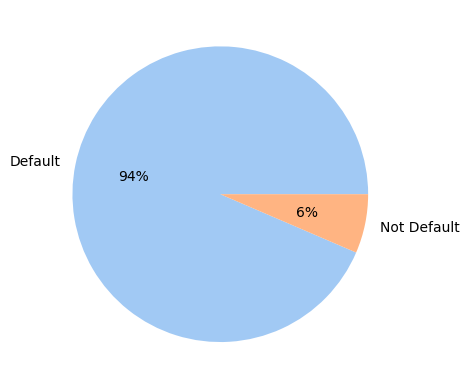

In [254]:
data = df['default_12m'].value_counts()
colors = sns.color_palette('pastel')[0:5]
labels = ['Default', 'Not Default']

plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

In [262]:
fig = px.scatter_matrix(data, dimensions=df.columns,
    labels={col:col.replace('_', ' ') for col in data.columns},
    height=900,
    color="Loan_Status",
    color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

AttributeError: 'Series' object has no attribute 'columns'

# Feature Engineering

In [255]:
df['ul_staff_range'].unique()

array(['[1-100]', '(100-500]', '> 500'], dtype=object)

In [256]:
encoder = TargetEncoder()
df['ul_staff_range'] = encoder.fit_transform(df['ul_staff_range'], df['record_id'])

/Users/litwein/opt/anaconda3/envs/dl/lib/python3.7/site-packages/category_encoders/target_encoder.py:124: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/Users/litwein/opt/anaconda3/envs/dl/lib/python3.7/site-packages/category_encoders/target_encoder.py:129: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [257]:
df

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m,set
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,...,3,3,136919.539012,50000.0,2,0,0,0,0.0,train
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,12,136919.539012,10000.0,5,0,0,0,0.0,train
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28,28,136919.539012,10000.0,2,0,0,0,0.0,train
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,...,8,8,136919.539012,300000.0,1,0,0,0,0.0,train
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,...,27,27,136919.539012,10000.0,2,0,0,0,0.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,265577,21287000.0,18838000.0,16227000.0,2611000.0,0.0,2449000.0,-123000.0,2326000.0,483000.0,...,32,32,136919.539012,10000.0,1,0,0,0,NaN,test
196,266648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6,6,136919.539012,0.0,1,0,0,0,NaN,test
197,266849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7,7,136919.539012,20000.0,1,0,0,0,NaN,test
198,267566,759009000.0,726682000.0,551903000.0,18323000.0,156456000.0,32327000.0,-23281000.0,9046000.0,431000.0,...,31,31,136919.539012,100000.0,2,0,0,0,NaN,test


# Feature Selection

# Model Selection and Evaluation

In [258]:
# Get a list of models to evaluate
def get_models():
    models = dict()
    models['LogisticRegression'] = LogisticRegression()
    models['SVC'] = SVC()
    models['GaussianNB'] = GaussianNB()
    models['MultinomialNB'] = MultinomialNB()
    models['SGDClassifier'] = SGDClassifier()
    models['DecisionTreeClassifier'] = DecisionTreeClassifier()
    models['RandomForestClassifier'] = RandomForestClassifier()
    models['GradientBoostingClassifier'] = GradientBoostingClassifier()
    # models['LGBMClassifier'] = LGBMClassifier()
    models['CatBoostClassifier'] = CatBoostClassifier()
    models['XGBClassifier'] = XGBClassifier()
    models['Stacking'] = get_stacking()
    return models

In [259]:
# Evaluate a given model using cross-validation
def roc_auc_evaluate_model(model, x, y):
    start_time = time.time()
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, x, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    run_time = time.time() - start_time
    return scores, run_time

In [260]:
# Get a stacking ensemble of models
def get_stacking():
    # Defining the base models
    level0 = list()
    level0.append(('LogisticRegression', LogisticRegression()))
    level0.append(('GradientBoosting', GradientBoostingClassifier()))
    level0.append(('CatBoost', CatBoostClassifier()))
    level0.append(('XGBClassifier', XGBClassifier()))
    level0.append(('GaussianNB', GaussianNB()))
    level0.append(('SGDClassifier', SGDClassifier()))
    # Defining meta learner model
    level1 = LogisticRegression()
    # Defining the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [261]:
# Get the models to evaluate
models = get_models()
roc_auc_results, names, runs = list(), list(), list()

# Evaluate the models and store results
for name, model in models.items():
    roc_auc_scores, run_time = roc_auc_evaluate_model(model, train_df.drop('default_12m', axis=1), train_df['default_12m'])
    roc_auc_results.append(roc_auc_scores)
    names.append(name)
    runs.append(run_time)
    print(name, "| ROC AUC:", mean(roc_auc_scores), "| Standard Deviation:", std(roc_auc_scores),"| Time Taken:", run_time)

ValueError: could not convert string to float: '[1-100]'

In [ ]:
roc_auc_mean_results, roc_auc_std_results = list(), list()
r2_mean_results, r2_std_results = list(), list()
for value in range(len(roc_auc_results)):
    roc_auc_mean_results.append(mean(roc_auc_results[value]))
    roc_auc_std_results.append(std(roc_auc_results[value]))

In [ ]:
data = {'Name':names, 'ROC AUC':roc_auc_mean_results, 'Standart Deviation':roc_auc_std_results, 'Time Taken':runs}
df_models = pd.DataFrame(data)
df_models.set_index('Name', inplace=True)
df_models

# Hyperparameter Tuning

# Results

In [ ]:
answ_df = pd.DataFrame()
answ_df['id'] = test_record_id
predict = pd.DataFrame([math.floor(float(x)) for x in (predictions*100)])
answ_df['predict'] = predict
answ_df.to_csv('PD-submit.csv',index=False, sep=';')